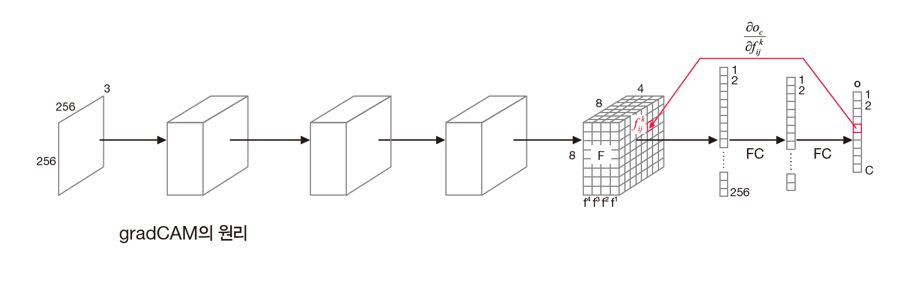

In [7]:
# GradCAM - Lin이 제안한 전역 평균 폴링 GAP(Global Average Pooling)
#  - 컨볼류션을 이용한 신경망의 구조를 획기적으로 줄여줄수 있는 알고리즘
# 가중치가 2만개 이상인 컨볼류션 신경망을 40개정도의 가중치가 있는 구조로 변경
# CAM은 혁신적인 아이디어지만.. 한계
# 전역 폴링에 의존, 전역 평균폴링을 사용하지 않는 모델에는 적용 불가   
# K번째 특징 맵의 그레디언트에 전역평균 폴링을 적용하는 것과 동일
from IPython.display import Image
Image("https://raw.githubusercontent.com/bigdataleeky/python/main/image/88.PNG", width=500)

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50, ResNet50
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [4]:
# 이미지를 기반으로한 신경망 모델을 불러온다.. 이미 만들어져 있음
model =  ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [5]:
model.summary() # ResNet50 모델 구조

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

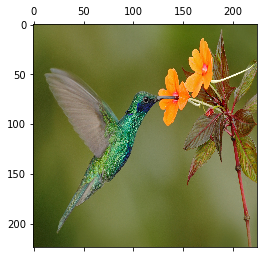

In [6]:
image_path = './hummingbird.jpg'
img = image.load_img(image_path,target_size=(224,224))
plt.matshow(img)

In [10]:
# 영상을 신경망 입력형태로 변환
x =  image.img_to_array(img)
x.shape

(224, 224, 3)

In [11]:
x = np.expand_dims(x, axis=0)
x.shape

(1, 224, 224, 3)

In [12]:
x = resnet50.preprocess_input(x)

In [15]:
preds =  model.predict(x)
print("예측결과:",resnet50.decode_predictions(preds,top=5)[0])

49152/35363 [=========================================] - 0s 0us/step
예측결과: [('n01833805', 'hummingbird', 0.99983835), ('n01843065', 'jacamar', 0.00010588149), ('n02280649', 'cabbage_butterfly', 1.0400287e-05), ('n01806143', 'peacock', 8.702703e-06), ('n02190166', 'fly', 4.189647e-06)]


In [16]:
# 신경망 모델의 특징 추출(컨볼류션층) 부분에서 마지막 층을 지정
# 특징 추출 부분만으로 구성된 모델 model_1 을 생성

In [17]:
last_conv_layer =  model.get_layer("conv5_block3_out")

In [18]:
model_1 = keras.Model(model.inputs,last_conv_layer.output)

In [22]:
# 분류(전역평균폴링 또는 안전연결층) 부분만으로 구성된 model_2 만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("avg_pool")(input_2)
x_2 = model.get_layer("predictions")(x_2)
model_2 = keras.Model(input_2,x_2)

In [33]:
with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1)
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]    

In [34]:
# 그레디언트 계산
grads = tape.gradient(output_2, output_1)
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2))

In [35]:
output_1 =  output_1.numpy()[0]
pooled_grads =  pooled_grads.numpy()

In [40]:
# GradCAm 적용
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i] *= pooled_grads[i]    
heatmap = np.mean(output_1,axis=-1)    

In [62]:
temp = np.asarray([[10,20,30,40,50],[20,50,40,30,10]])
np.maximum(temp,20)

array([[20, 20, 30, 40, 50],
       [20, 50, 40, 30, 20]])

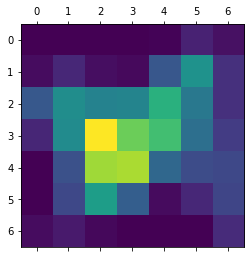

In [44]:
# 0, 1 정규화
heatmap =  np.maximum(heatmap,0)/np.max(heatmap) # 음수는 0으로 변경후 정규화 함
plt.matshow(heatmap)

In [63]:
# 열지도를 입력영상에 덧씌우는 작업
img = image.load_img(image_path)
img = image.img_to_array(img)
heatmap = np.uint8(255*heatmap)  # 0 ~ 255 로 변환